**Introduction**

Project link: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
<br>Problem: Can track features predict the popularity of a track on Spotify?
<br>Data: tabular, mostly numerical, with some categorical and binary features
<br>Type: Supervised regression


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# data loading and initial look
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
# checking size
df.shape

(114000, 21)

In [8]:
# checking for missing values
df_missing = df.isnull().sum()
df_missing

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [9]:
# checking for feature ranges
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [10]:
# making a table to describe features - before better cleaning and removing track names, id, and more categorical track info
def summarize_features(df, categorical_threshold=10):
    summary = []

    for col in df.columns:
        col_data = df[col]
        missing = col_data.isnull().sum()

        if col_data.dtype == 'object' or df[col].nunique() <= categorical_threshold:
            feature_type = "Categorical"
            values = ", ".join(map(str, col_data.dropna().unique()[:5]))
            if df[col].nunique() > 5:
                values += ", ..."
            outliers = "N/A"
        else:
            feature_type = "Numerical"
            values = f"{col_data.min()} to {col_data.max()}"

            # Outlier detection using IQR
            Q1 = col_data.quantile(0.25)
            Q3 = col_data.quantile(0.75)
            IQR = Q3 - Q1
            outlier_mask = (col_data < (Q1 - 1.5 * IQR)) | (col_data > (Q3 + 1.5 * IQR))
            outliers = outlier_mask.sum()

        summary.append({
            "Feature": col,
            "Type": feature_type,
            "Values/Range": values,
            "Missing Values": missing,
            "Outliers": outliers
        })

    return pd.DataFrame(summary)

summary_table = summarize_features(df)

print(summary_table)


             Feature         Type  \
0         Unnamed: 0    Numerical   
1           track_id  Categorical   
2            artists  Categorical   
3         album_name  Categorical   
4         track_name  Categorical   
5         popularity    Numerical   
6        duration_ms    Numerical   
7           explicit  Categorical   
8       danceability    Numerical   
9             energy    Numerical   
10               key    Numerical   
11          loudness    Numerical   
12              mode  Categorical   
13       speechiness    Numerical   
14      acousticness    Numerical   
15  instrumentalness    Numerical   
16          liveness    Numerical   
17           valence    Numerical   
18             tempo    Numerical   
19    time_signature  Categorical   
20       track_genre  Categorical   

                                         Values/Range  Missing Values Outliers  
0                                         0 to 113999               0        0  
1   5SuOikwiRyPMVoIQDJU

**Target Variable**: Popularity, ranges from 0 - 100

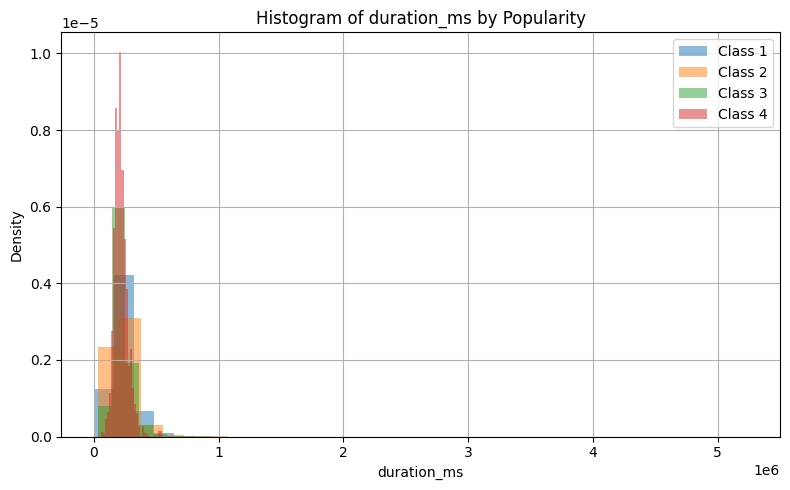

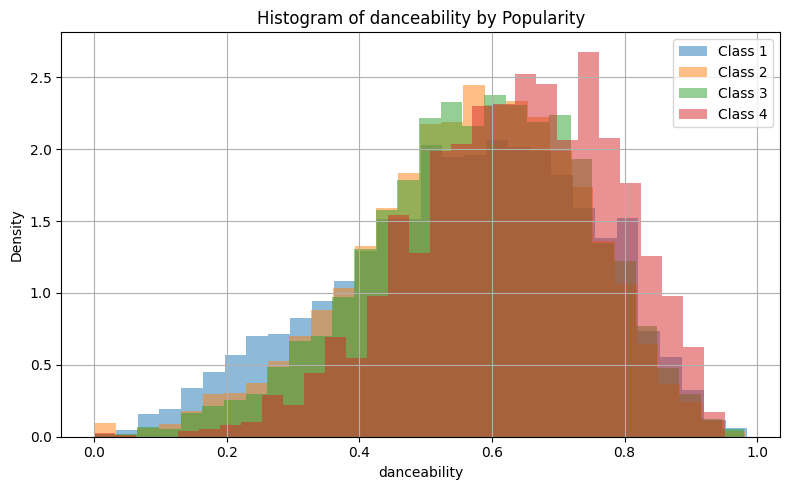

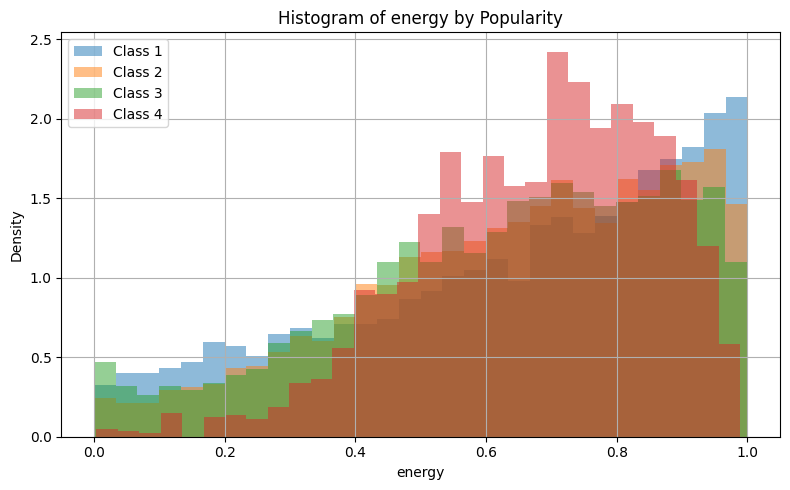

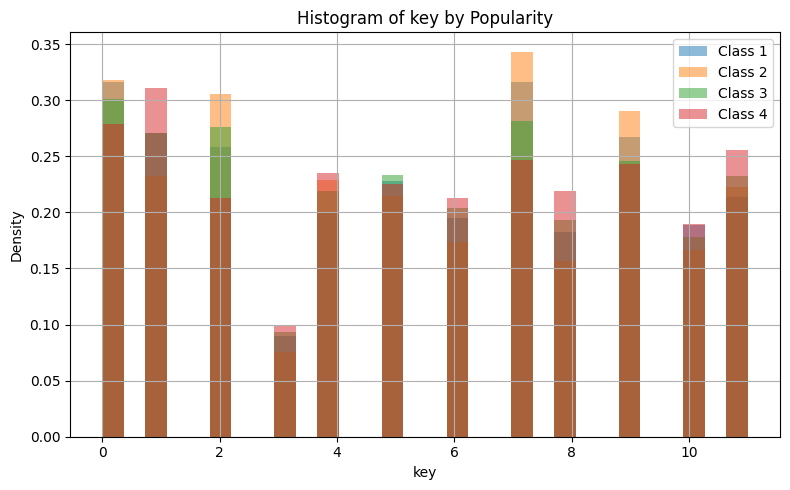

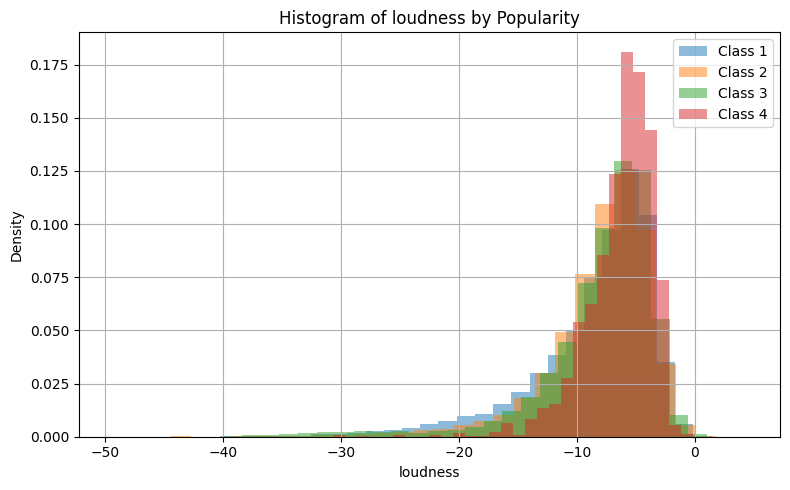

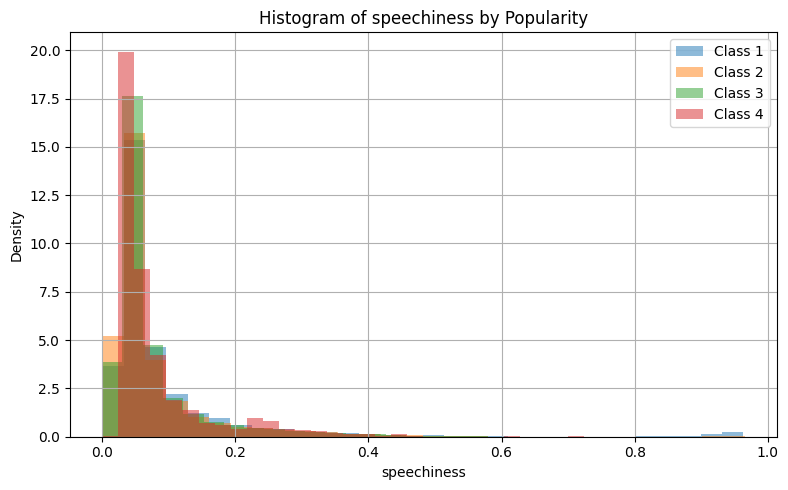

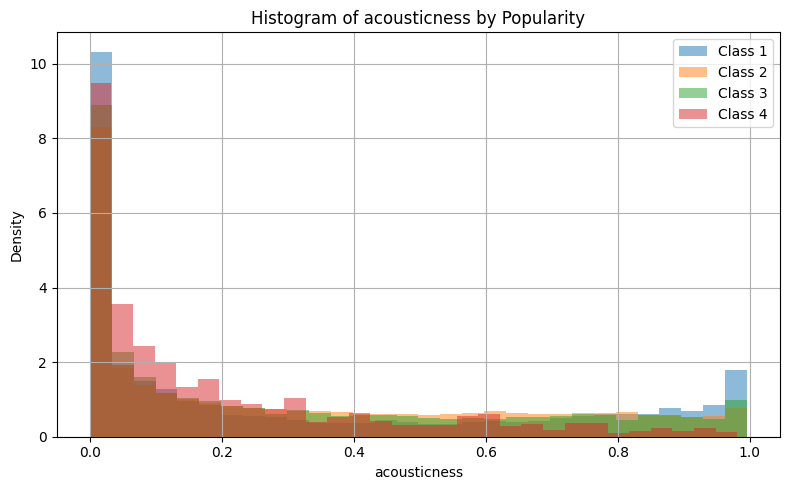

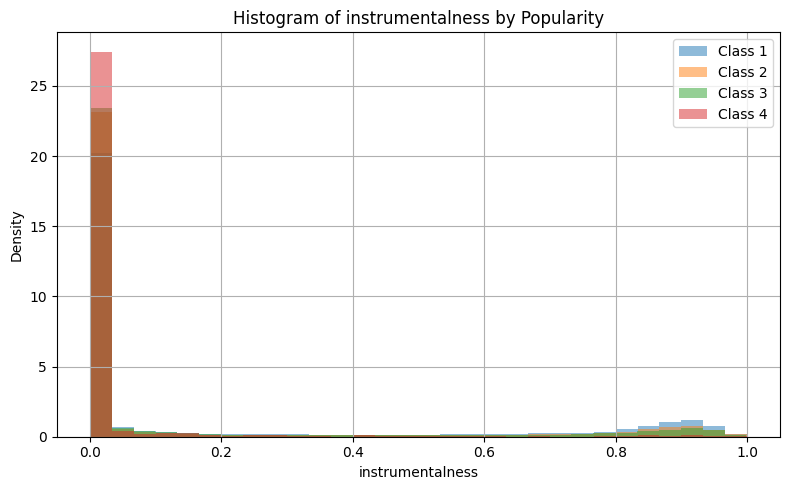

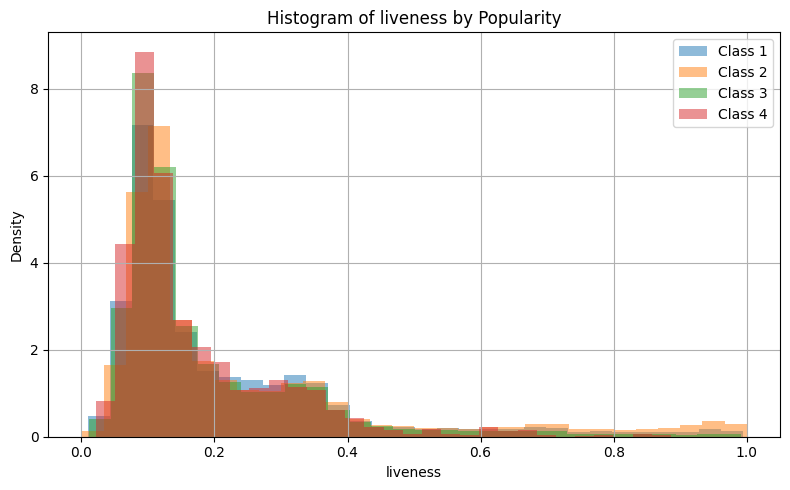

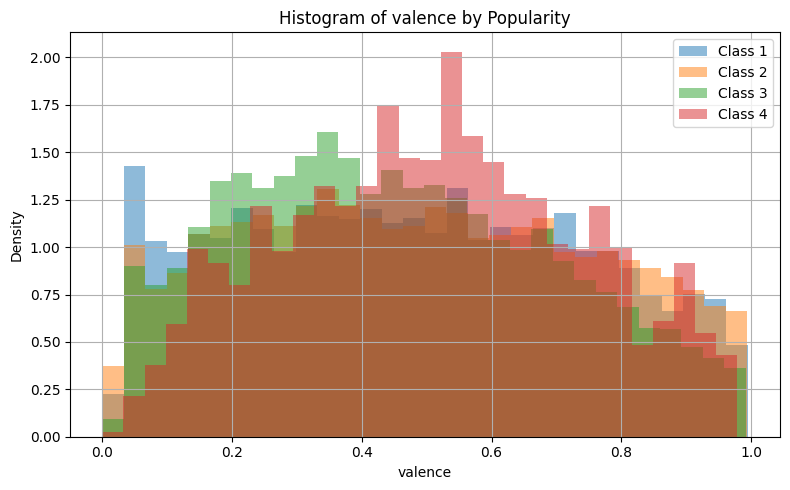

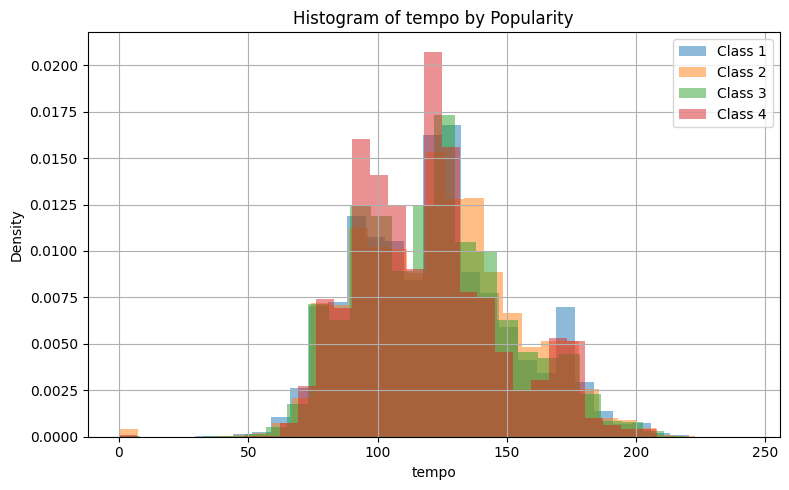

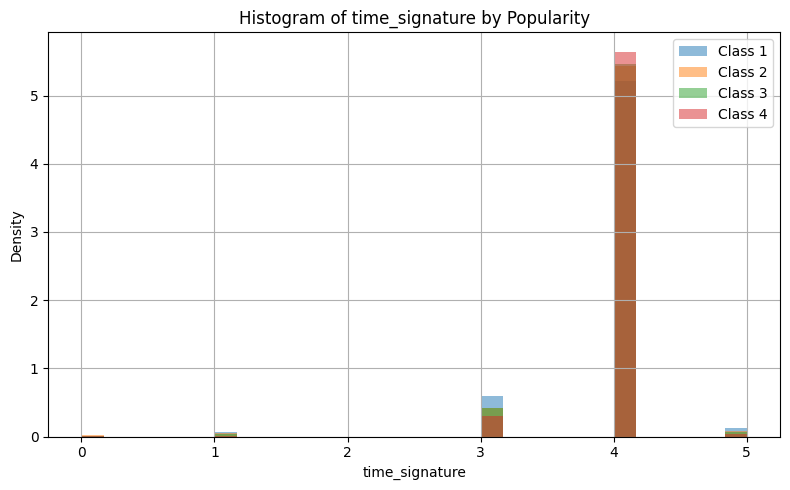

In [14]:
# data visualization

# Assume your regression target column is called 'target'
# Define bins and labels
bins = [0, 25, 50, 75, 100]
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# Bin the target
df['target_class'] = pd.cut(df['popularity'], bins=bins, labels=labels, include_lowest=True)

# Choose features to compare
features_to_plot = ['duration_ms', 'danceability', 'energy', 'key', 
                    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
                    'liveness', 'valence', 'tempo', 'time_signature']

# Plot histograms for each feature
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    for label in labels:
        subset = df[df['target_class'] == label]
        plt.hist(subset[feature].dropna(), bins=30, alpha=0.5, label=label, density=True)
    
    plt.title(f"Histogram of {feature} by Popularity")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
# 'instrumentalness', 'time_signature', 'loudness', 'danceability' all look interesting in terms of determining popularity